# Interrogate crop poylgon to explore phenology

**What does this notebook do?:** This notebook pulls in data for all available sensors (LS5, LS7, LS8, S2a, S2b) based on the extent of a provided polygon. The polygon is then used to mask the data, and the average NDWI is calculated for the entire polygon. The user can select a point on a scatter plot and draw the false colour image for that scene. 

**Required inputs:** A shape file containing the polygon you would like to use for the analysis. This script also uses a GeoTiff to plot behind the polygons to provide context. This is optional, but will need to be removed from the workflow manually if you do not wish to use one.

**Before you run this notebook**: You need to run the following commands from the command line prior to launching jupyter notebook from the same terminal so that the required libraries and paths are set.

`module use /g/data/v10/public/modules/modulefiles`

`module load dea`

**Date:** September 2018

**Author:** Claire Krause

In [1]:
%pylab notebook

from datacube.storage import masking
from datacube import Datacube
from datacube.utils import geometry
import fiona
import rasterio.features
import xarray as xr
import shapefile as shpf
import shapely

# Import widgets for interactive notebook
import ipywidgets as widgets

import sys
import os
sys.path.append('../10_Scripts')
import DEADataHandling
import BandIndices

dc = Datacube(app = 'crop phenology')

Populating the interactive namespace from numpy and matplotlib


## Set up our widget function

We want the widget to automatically
- extract and cloud mask data for all sensors (LS5, LS7, LS8, S2a, S2b)
- calculate the polygon averaged NDVI for each time step and sensor

In [2]:
def onclick_polygon_interrogation(event):
    global pixelx, pixely, AlldataMasked, FieldMean, Clickedpolygon
    pixelx, pixely = int(event.xdata), int(event.ydata)
    # Generate a point from the location
    Clickpoint = shapely.geometry.Point(pixelx, pixely)
    IrrigatedShapes = IrrigatedPolygons.shapes()
    # Find the polygon that contains the selected point
    Clickedpolygon = []
    for ix, shapes in enumerate(IrrigatedPolygons.shapes()):
        if shapely.geometry.shape(shapes).contains(Clickpoint) == True:
            Clickedpolygon.append(ix)
    # Colour the chosen polygon on the figure
    x = [i[0] for i in IrrigatedShapes[Clickedpolygon[0]].points[:]]
    y = [i[1] for i in IrrigatedShapes[Clickedpolygon[0]].points[:]]
    
    plt.figure(fig1.number)
    plt.plot(x, y, 'r')
    
    # Grab the geometry from the polygon we want to interrogate
    with fiona.open(shape_file) as shapes:
        crs = geometry.CRS(shapes.crs_wkt)
        first_geometry = shapes[Clickedpolygon[0]]['geometry']
        geom = geometry.Geometry(first_geometry, crs=crs)

    querys2 = {'output_crs': 'EPSG:3577',
               'resolution': (-10, 10),
               'geopolygon': geom,
               'time':(start_date, end_date)
              }
    queryls = {'geopolygon': geom,
               'time':(start_date, end_date)
              }

    # dc.load the data using the polygon as the bounds
    Alldata = dict()
    for Sensor in AllSensors:
        if Sensor[0] == 'l':
            try:
                Alldata[Sensor], LScrs, LSaffine = DEADataHandling.load_nbarx(dc, Sensor, queryls, product = 'nbart')
            except TypeError:
                print('No data available for {}'.format(Sensor))
        if Sensor[0] == 's':
            prodname = '{0}_ard_granule'.format(Sensor)
            try:
                Alldata[Sensor], S2crs, S2affine = DEADataHandling.load_sentinel(dc, prodname, querys2)
            except TypeError:
                print('No data available for {}'.format(Sensor))

    # Tidy up our dict to remove any empty keys
    for Sensor in AllSensors:
        try:
            Alldata[Sensor]
            if Alldata[Sensor] is None:
                del Alldata[Sensor]
            else:
                try:
                    Alldata[Sensor].time
                except AttributeError:
                    del Alldata[Sensor]
        except KeyError:
                pass

    # Mask the returned data with the polygon to remove any extra data
    AlldataMasked = Alldata.copy()
    for Sensor in Alldata.keys():
        mask = rasterio.features.geometry_mask([geom.to_crs(Alldata[Sensor].geobox.crs) for geoms in [geom]],
                                               out_shape=Alldata[Sensor].geobox.shape,
                                               transform=Alldata[Sensor].geobox.affine,
                                               all_touched=False,
                                               invert=True)
        AlldataMasked[Sensor] = Alldata[Sensor].where(mask)

    # Calculate the NDVI for each sensor
    for Sensor in AllSensors:
        try:
            AlldataMasked[Sensor]['NDVI'] = BandIndices.calculate_indices(AlldataMasked[Sensor], 'NDVI')
        except KeyError:
            pass

    # Concatenate all out 
    Allvalues = xr.concat([masked.NDVI for masked in AlldataMasked.values()], dim='time')
    Allvalues = Allvalues.sortby('time')
    Allvalues.values[Allvalues.values == -999] = np.nan
    FieldMean = Allvalues.mean(dim = ('x', 'y')).dropna(dim = 'time')

## Set up our inputs and analysis parameters

### Polygon input and contextual Geotiff

Note that the GeoTiff input layer isn't actually used in the analysis. It is only there to provide context to the polygons

In [3]:
# Path to the polygon file we are using to perform the polygon drills
shape_file = '/g/data/r78/cek156/dea-notebooks/Crop_mapping/NamoiPilotProject/Summer201718/NamoiIrrigated201718Summer.shp'
# This is a tif file to plot behind the polygons for context
MaxNDVIFile = '/g/data/r78/cek156/datacube_stats/Namoi_summer/NDVI/ndvi_None_20171101.tif'

### Set up the list of sensors for the analysis

If you would like to leave out a sensor, simply remove it from this list.

`AllSensors = ['ls5', 'ls7', 'ls8', 's2a', 's2b']`

In [4]:
AllSensors = ['ls5', 'ls7', 'ls8', 's2a', 's2b']

### Choose the time period for the analysis

In [5]:
global start_date, end_date
start_date = '2017-10-01'
end_date = '2018-04-30'

## Read in the shapefile and GeoTiff

In [6]:
IrrigatedPolygons = shpf.Reader(shape_file)
NDVIData = xr.open_rasterio(MaxNDVIFile)

## Click on the polygon you would like to interrogate

You can use the tools at the bottom of the figure window to zoom in and scroll around the plot. Once you have selected a polygon, the widget will perform the data extraction and create field averaged NDVI values. Once the script has finished executing, the polygon you selected will turn red. 

**Note** this script is relatively slow, and may take a couple of minutes to perform the data extraction.

<IPython.core.display.Javascript object>


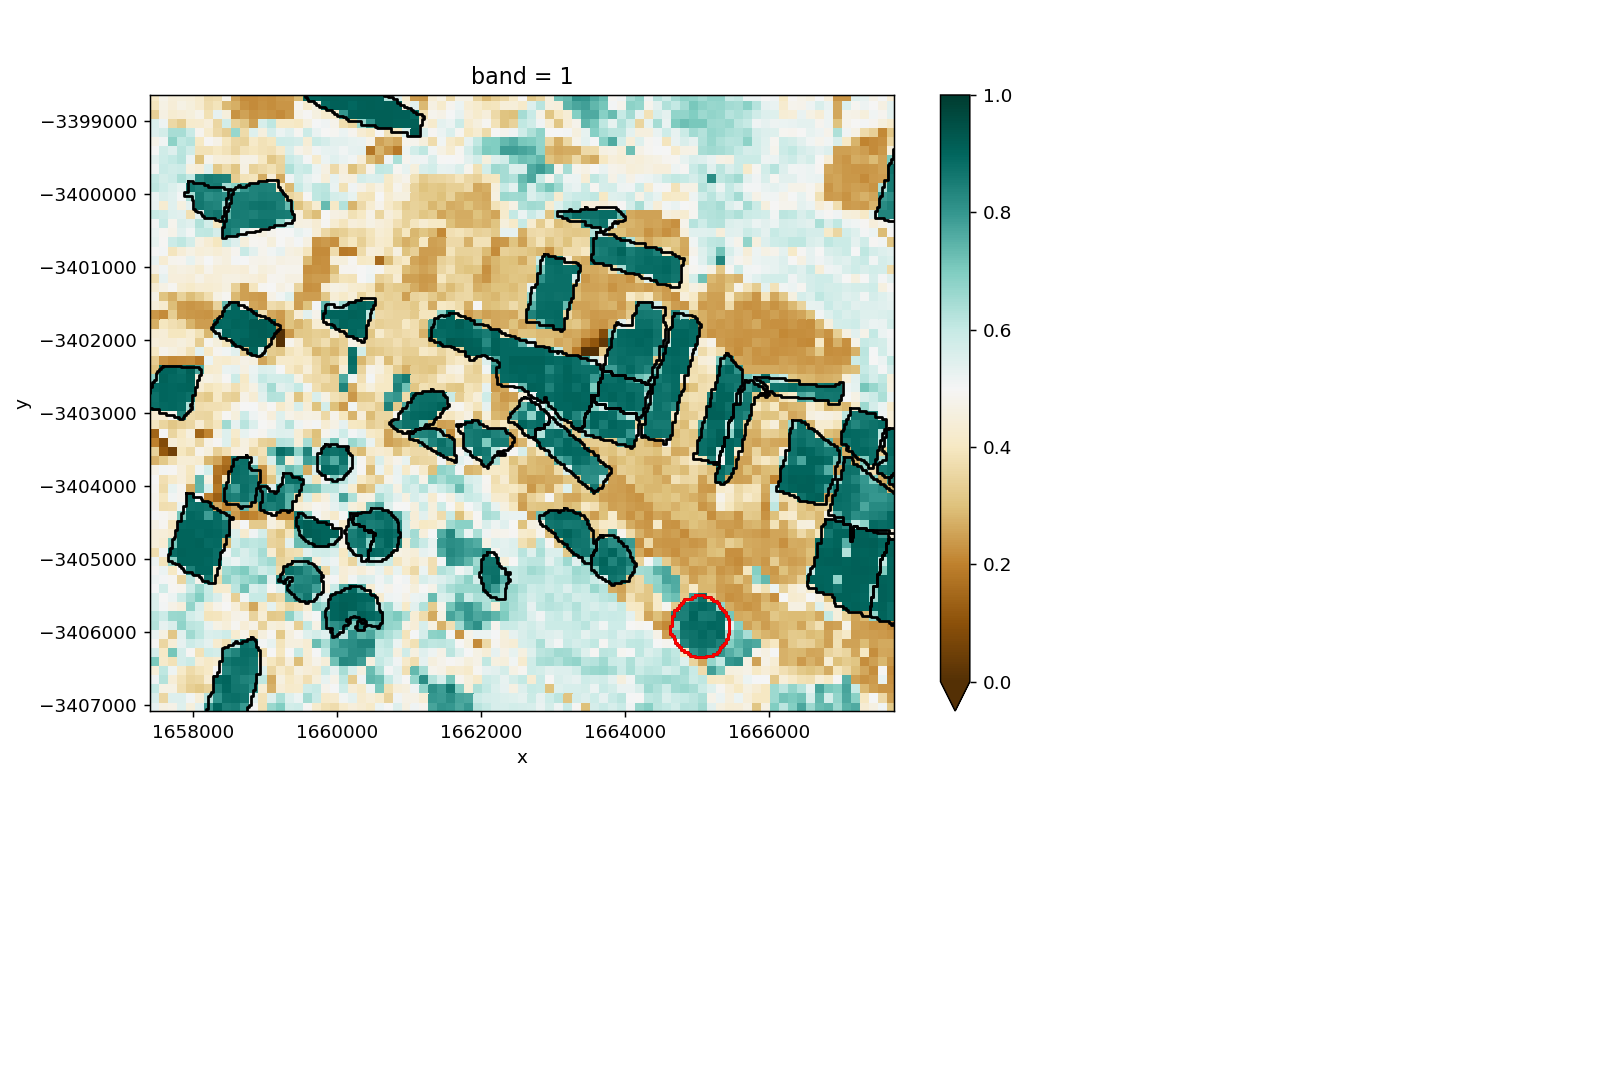

HTML(value='Click inside the polygon you would like to interrogate')

In [7]:
fig1 = plt.figure(figsize=[9, 6])

NDVIData.isel(x=range(0, len(NDVIData.x), 5),
              y=range(0, len(NDVIData.y), 5)).plot(cmap = 'BrBG', vmin=0, vmax = 1)

for shape in IrrigatedPolygons.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')
plt.show()

w = widgets.HTML("Click inside the polygon you would like to interrogate")

cid = fig1.canvas.mpl_connect('button_press_event', onclick_polygon_interrogation)
display(w)

## Plot the mean field NDVI for each observation over the growing season

<IPython.core.display.Javascript object>


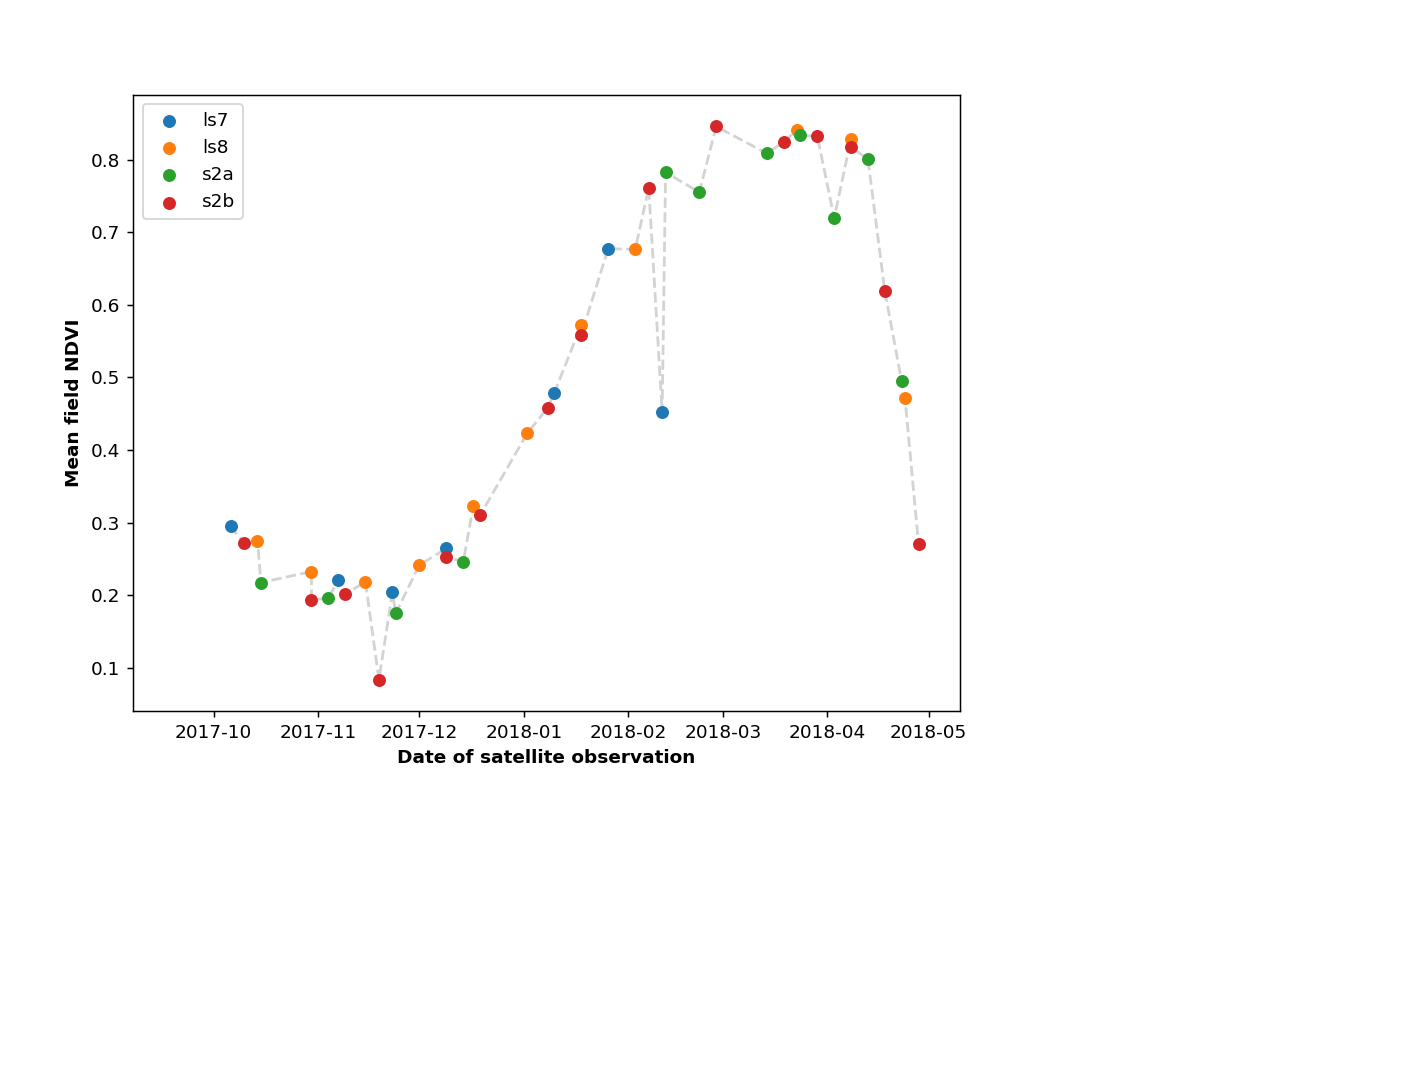

Text(0,0.5,'Mean field NDVI')

In [8]:
fig = plt.figure(figsize = [8, 6])

for Sensor in AllSensors:
    try:
        plt.scatter(AlldataMasked[Sensor].time.values, AlldataMasked[Sensor]['NDVI'].mean(dim = ('x', 'y')).values)
    except KeyError:
        pass
plt.legend(AlldataMasked.keys(), loc = 'upper left')
plt.plot(FieldMean.time, FieldMean, 'lightgrey', linestyle = '--', zorder = 0)

plt.xlabel('Date of satellite observation', fontweight = 'bold')
plt.ylabel('Mean field NDVI', fontweight = 'bold')